# How to run this notebook

In order to run this notebook using Poetry, you first need to create a kernel that uses the virtualenv that you use for SeaGOAT development.

In order to do that, you can run the following commands:

```bash
poetry run python -m ipykernel install --user --name seagoat-poetry
```

In [582]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [583]:
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.getipython import get_ipython
from IPython.display import Javascript

In [584]:
from load_results import load_results
from load_results import get_percentage_of_queries_with_correct_results
from load_results import get_percentage_of_examples_with_correct_results
from load_results import get_positions_of_correct_results
from load_results import get_best_position_of_correct_results
from load_results import get_average_position_of_a_correct_results
from load_results import get_list_of_test_runs
from load_results import get_chance_of_getting_correct_result_in_n_lines

list_of_test_runs = get_list_of_test_runs()
list_of_test_runs

['gt -C1', 'gt -C2', 'initial test']

In [585]:
results = load_results("gt -C2")

## Quality of example cases

(array([ 9.,  0.,  0.,  0.,  0.,  2.,  3.,  4.,  1.,  0.,  0.,  0.,  3.,
        12., 21., 13.,  3.,  2.,  2.,  5.,  9., 28., 16.,  7.,  1.]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ,
        41.8, 45.6, 49.4, 53.2, 57. , 60.8, 64.6, 68.4, 72.2, 76. , 79.8,
        83.6, 87.4, 91.2, 95. ]),
 <BarContainer object of 25 artists>)

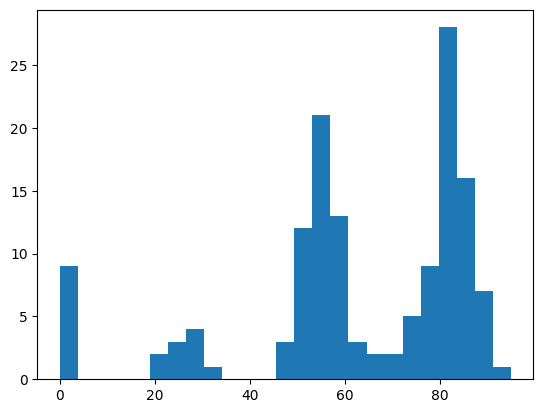

In [586]:
plt.hist([x['qualityScore'] for x in results], 25)

### Total number of examples

In [587]:
len(results)

141

### Number of examples after quality cutoff

In [588]:
results = [result for result in results if result['qualityScore'] >= 75]
len(results)

62

(array([ 4.,  5.,  8., 10., 12., 15.,  3.,  2.,  2.,  1.]),
 array([75., 77., 79., 81., 83., 85., 87., 89., 91., 93., 95.]),
 <BarContainer object of 10 artists>)

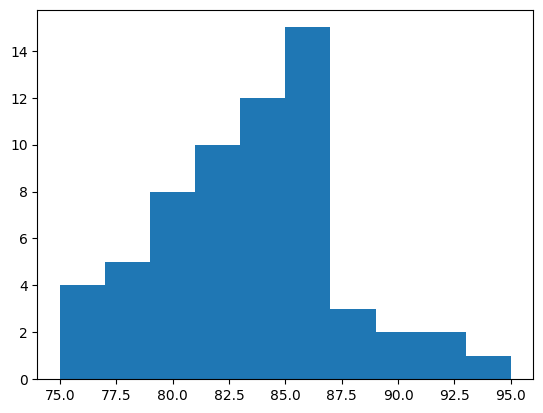

In [589]:
plt.hist([x['qualityScore'] for x in results], 10)

## % of queries resulting in a correct result

In [590]:
get_percentage_of_queries_with_correct_results(results, "random")

1.3856812933025404

In [591]:
get_percentage_of_queries_with_correct_results(results, "seagoat")

50.57736720554272

## % of examples with at least one query resulting in a correct result

In [592]:
get_percentage_of_examples_with_correct_results(results, 'random')

9.67741935483871

In [593]:
get_percentage_of_examples_with_correct_results(results, 'seagoat')

91.93548387096774

## Position of correct result when a correct result is found

(array([2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([10.  , 12.35, 14.7 , 17.05, 19.4 , 21.75, 24.1 , 26.45, 28.8 ,
        31.15, 33.5 , 35.85, 38.2 , 40.55, 42.9 , 45.25, 47.6 , 49.95,
        52.3 , 54.65, 57.  ]),
 <BarContainer object of 20 artists>)

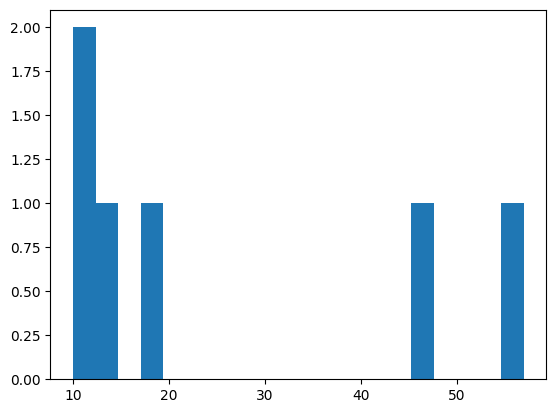

In [594]:
plt.hist(get_positions_of_correct_results(results, 'random'), 20)

(array([54., 47., 25., 17.,  7., 15., 11.,  2.,  3.,  6.,  7.,  6.,  2.,
         0.,  5.,  0.,  0.,  0.,  7.,  5.]),
 array([  2.,  10.,  18.,  26.,  34.,  42.,  50.,  58.,  66.,  74.,  82.,
         90.,  98., 106., 114., 122., 130., 138., 146., 154., 162.]),
 <BarContainer object of 20 artists>)

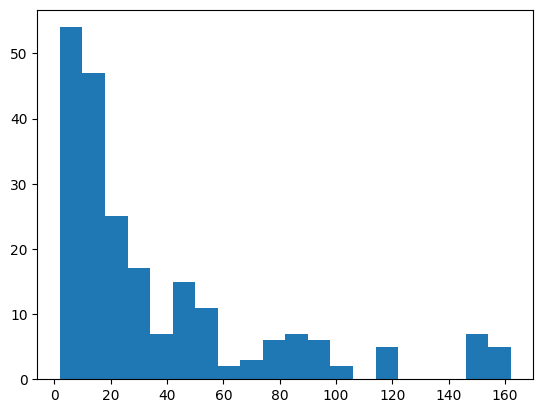

In [595]:
plt.hist(get_positions_of_correct_results(results, 'seagoat'), 20)

## Best result position for examples

(array([11., 13.,  9.,  3.,  3.,  4.,  3.,  1.,  2.,  1.,  1.,  1.,  1.,
         0.,  2.,  0.,  0.,  0.,  1.,  1.]),
 array([  2.,  10.,  18.,  26.,  34.,  42.,  50.,  58.,  66.,  74.,  82.,
         90.,  98., 106., 114., 122., 130., 138., 146., 154., 162.]),
 <BarContainer object of 20 artists>)

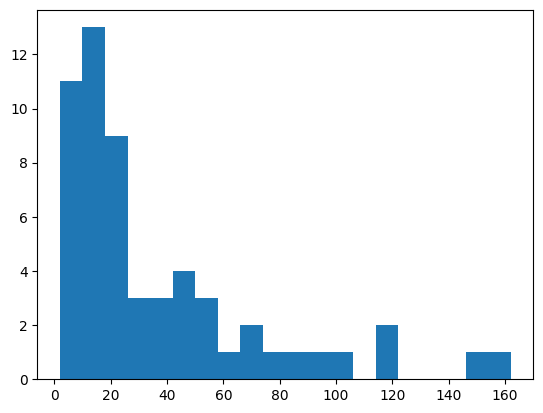

In [596]:
plt.hist(get_best_position_of_correct_results(results, 'seagoat'), 20)

## Average position of correct results

In [597]:
get_average_position_of_a_correct_results(results, 'seagoat')

36.75342465753425

## Chance of correct result by line N (%)

<BarContainer object of 500 artists>

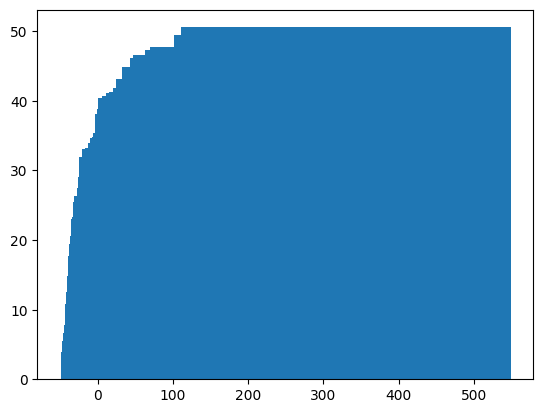

In [598]:
plt.bar(range(500), get_chance_of_getting_correct_result_in_n_lines(results, 'seagoat'), 100)